# 三次样条插值原理及实现
> 参考[python数据分析系列——三次样条插值理论推导、自定义实现与scipy实现](https://zhuanlan.zhihu.com/p/672601034?utm_id=0)  
> 并在原文基础上做了些改动:
> 1. 支持端点之外的插值;
> 2. 数据存储保存在三个向量当中, 而不是保存在一个矩阵中, 节约存储空间
> 3. 系数求解没有采用np自带的求解方法而是自己实现的三对角的求解法, 支持将算法移植到c++/c等.

## 1. 简介
在区间段$[a, b]$上划分为$[(x_0, x_1), (x_1, x_2), ..., (x_{n-1}, x_{n})]$，其中$a=x_0, b=x_n$, 因此有n+1个点和n个区间段。

三次样条就是说每个小区间的曲线是一个三次方程，三次样条方程满足以下条件：
1. 在每个分段小区间$S(x_i)=y_i$上，$S(x)=S_i(x)$都是一个三次方程
2. 满足插值条件，即$S(x_i)=y_i, i=(0,1,...,n)$
3. 曲线光滑，即$S(x)$, $S'(x)$, $S''(x)$ 连续


而三次方程可以构造成如下形式:  
$S_i(x)=a_i+b_ix+c_ix^2+d_ix^3$

从$S_i(x)$可以看出每个小区间有四个未知数 $a_i, b_i, c_i, d_i$ , 有n个小区间，则有4n个未知数，要解出这些未知数，则我们需要4n个方程来求解。

## 2. 求解条件

我们要找出4n个方程来求解4n个未知数

首先，由于所有点必须满足插值条件(条件 2)，$S(x_i)=y_i, i=(0,1,...,n)$, 除了两个端点，所有n-1个内部点的每个点都满足$S_i(x_{i+1})=y_{i+1}, S_{i+1}(x_{i+1})=y_{i+1}$, 即$S(x)$连续, 前后两个分段三次方程，则有2(n-1)个方程，再加上两个端点分别满足第一个和最后一个三次方程，则总共有2n个方程；

其次，n-1个内部点的一阶导数应该是连续的，即在第 i 区间的末点和第 i+1 区间的起点是同一个点，它们的一阶导数应该也相等，即 $S_i'(x_{i+1})=S_{i+}'(x_{i+1})$则有n-1个方程

另外，内部点的二阶导数也要连续，即$S_i''(x_{i+1})=S_{i+}''(x_{i+1})$,也有n-1个方程

现在总共有4n-2个方程了，还差两个方程就可以解出所有未知数了，这两个方程我们通过边界条件得到。

有三种边界条件：自然边界，固定边界，非节点边界

1. 自然边界 ( Natural Spline )：指定端点二阶导数为0，$f_0''(x_0)=0=f_{n-1}''(x_n)$
2. 固定边界 ( Clamped Spline ): 指定端点一阶导数，这里分别定为A和B。即 $f'_0(x_0)=A,\quad f_{n-1}'(x_n)=B$
3. 非扭结边界( Not-A-Knot Spline ): 强制第一个插值点的三阶导数值等于第二个点的三阶导数值，最后第一个点的三阶导数值等于倒数第二个点的三阶导数值. 即 $f'''_0(x_0)=f'''_1(x_1) \quad and \quad f'''_{n-2}(x_{n-1})=f'''_{n-1}(x_n) $

## 3. 具体推导
### 3.1 根据插值和导数连续的条件设置方程
每一个区间段的三次函数设为$f_i(x), i=[0,...,n-1]$ 则有
$$
\begin{aligned} f_{i}(x) &=a_{i}+b_{i}\left(x-x_{i}\right)+c_{i}\left(x-x_{i}\right)^{2}+d_{i}\left(x-x_{i}\right)^{3} \\ f_{i}^{\prime}(x) &=b_{i}+2 c_{i}\left(x-x_{i}\right)+3 d_{i}\left(x-x_{i}\right)^{2} \\ f_{i}^{\prime \prime}(x) &=2 c_{i}+6 d_{i}\left(x-x_{i}\right) \end{aligned}
$$

1. 根据插值定义，每一段函数的左端点等于其函数值，可得n个方程
   $$\begin{aligned} & f_i(x_i) = a_i+b_i(x_i-x_i)+c_i(x_i-x_i)^2+d_i(x_i-x_i)^3 = a_i \\ &\Longrightarrow a_i = y_i ,其中i=[0,...,n-1] \end{aligned} \tag{1}$$
2. 根据插值定义，每一段函数的右边端点等于其函数值，可得n个方程
   $$\begin{aligned} &f_i(x_{i+1}) = a_i+b_i(x_{i+1}-x_i)+c_i(x_{i+1}-x_i)^2+d_i(x_{i+1}-x_i)^3 ,令h_i=x_{i+1}-x_i\\ &\Longrightarrow a_i+h_ib_i+h_i^2c_i+h_i^3d_i = y_{i+1} ,其中i=[0,...,n-1] \end{aligned} \tag{2}$$
3. 根据一阶导数连续条件，除首位端点外，中间n-1个端点的左右一阶导数相等，可得n-1个方程
   $$\begin{aligned} &f'_i(x_{i+1}) = f'_{i+1}(x_{i+1}) \\ &\Longrightarrow b_i+2c_i(x_{i+1}-x_i)+3d_i(x_{i+1}-x_i)^2 = b_{i+1}+2c_{i+1}(x_{i+1}-x_{i+1})+3d_{i+1}(x_{i+1}-x_{i+1})^2,\\ &\Longrightarrow b_i+2c_ih_i+3d_ih_i^2 = b_{i+1},其中i=[0,...,n-2] \end{aligned} \tag{3}$$
4. 根据二阶导数连续条件，除首位端点外，中间n-1个端点的左右二阶导数相等，可得n-1个方程
$$\begin{aligned} &f''_i(x_{i+1}) = f''_{i+1}(x_{i+1}) \\ &\Longrightarrow 2c_i+6d_i(x_{i+1}-x_i) = 2c_{i+1}+6d_{i+1}(x_{i+1}-x_{i+1}),\\ &\Longrightarrow 2c_i+6d_ih_i = 2c_{i+1},其中i=[0,...,n-2] \end{aligned} \tag{4} $$


理论上来说可以对上面的4n个方程（加上边界条件）和未知数直接求解，不过这样效率会比较低，建议可以先人工进行消元,注意下面消元得时候i的下标。

## 3.2 方程的消元过程
(略)
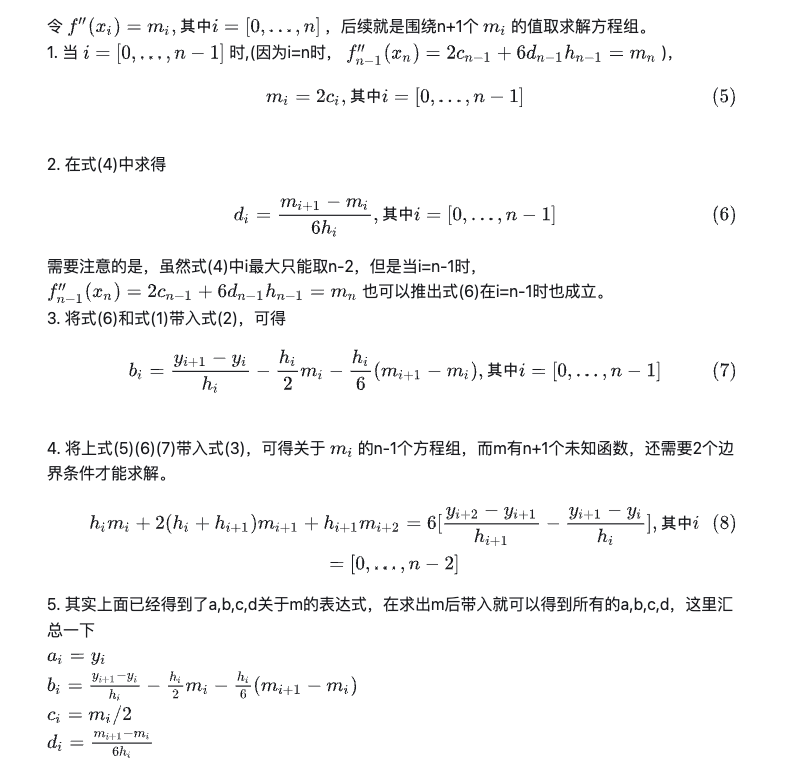

## 3.3 消元结果
1. 自然边界 (Natural Spline)
$$ \begin{bmatrix} 2 & 0 &0 &0 &\cdots &0 \\ h_0 & 2(h_0+h_1) & h_1 & 0 &\cdots &0 \\ 0 & h_1 & 2(h_1+h_2) & h_2 &\cdots &0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 &\vdots & 0 &h_{n-2} &2(h_{n-2}+ h_{n-1})&h_{n-1}\\ 0 &\vdots &\vdots& 0 &0 &2 \end{bmatrix} \begin{bmatrix} m_0 \\ m_1 \\ m_2 \\ \vdots \\ m_{n-1} \\ m_{n} \end{bmatrix} = 6 \begin{bmatrix} 0 \\ \frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\ \frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\ \vdots \\ \frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}} \\ 0 \end{bmatrix} $$
2. 固定边界 (Clamped Spline)
3. 非扭结边界 (Not-A-Knot Spline)